# Assign RegulatoryOverlayUUIDs Values to Water Right sites.csv
Purpose:  To assign RegulatoryOverlayUUIDs values to state water right sites.csv File.

Notes: 
- requires the completed pre-processed sites.csv & watersource.csv files from the state "WaterAllocation/ProcessedInputData" folder to be copied over to the "Regulatory/ProcessedInputData" folder.  Rename to wr_sites.csv & wr_watersource.csv to preserve inputs.
- requires awareness of unique WaterSourceTypeCV of each water right site match up to corresponding WaterSourceTypeCV of regulatoryoverlays per reportingunits

In [1]:
# Needed Libraries / Modules

# ---- working with data ----
import os  # native operating system interaction
import numpy as np  # mathematical array manipulation
import pandas as pd  # data structure and data analysis
import geopandas as gpd  # geo-data structure and data analysis

# ---- visualization ----
import matplotlib.pyplot as plt  # plotting library
import seaborn as sns  # plotting library
import geoplot as gplt # for plotting maps
import geoplot.crs as gcrs #used to pull in webdata

# ---- API data retrieval ----
import requests  # http requests
import json  # JSON parse

# ---- Cleanup ----
import re  # string regular expression manipulation
from datetime import datetime  # date and time manipulation
pd.set_option('display.max_columns', 999)  # How to display all columns of a Pandas DataFrame in Jupyter Notebook
pd.set_option('display.float_format', lambda x: '%.5f' % x)  # suppress scientific notation in Pandas

In [2]:
# ---- working directory ----
workingDirString = "G:/Shared drives/WaDE Data/Wyoming/Regulatory" # set working directory folder string here
os.chdir(workingDirString)
print(f'The working Directory is:', workingDirString)

The working Directory is: G:/Shared drives/WaDE Data/Wyoming/Regulatory


## Input Data

In [3]:
# Regulatory Input Data
dfro = pd.read_csv("ProcessedInputData/regulatoryoverlays.csv")
dfru = pd.read_csv("ProcessedInputData/reportingunits.csv")
dfrru = pd.read_csv("ProcessedInputData/regulatoryreportingunits.csv")

# Water right Input Data
dfws = pd.read_csv('ProcessedInputData/wr_watersources.csv')
dfs = pd.read_csv('ProcessedInputData/wr_sites.csv', engine = "python", error_bad_lines=False)

C:\Users\rjame\AppData\Local\Temp\ipykernel_21116\447271929.py:8: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  dfs = pd.read_csv('ProcessedInputData/wr_sites.csv', engine = "python", error_bad_lines=False)


In [4]:
#### regulatory watersource info with reporting unit info

# merge regulatoryoverlays -to- regulatoryreportingunits -to- reportingunits
dfro = pd.merge(dfro[['RegulatoryOverlayUUID', 'WaterSourceTypeCV']], dfrru[['RegulatoryOverlayUUID', 'ReportingUnitUUID']], left_on='RegulatoryOverlayUUID', right_on='RegulatoryOverlayUUID', how='left')
dfru = pd.merge(dfru, dfro, left_on='ReportingUnitUUID', right_on='ReportingUnitUUID', how='left')

print(dfru['WaterSourceTypeCV'].unique()) # check WaterSourceTypeCV for unique values for
print(len(dfru))
dfru.head(1)

['Surface and Groundwater']
35


,ReportingUnitUUID,EPSGCodeCV,ReportingUnitName,ReportingUnitNativeID,ReportingUnitProductVersion,ReportingUnitTypeCV,ReportingUnitUpdateDate,StateCV,Geometry,RegulatoryOverlayUUID,WaterSourceTypeCV
0,WYre_RUwy1,4326,Campbell County Conservation,wy1,NaN,Conservation Districts,7/30/2023,WY,POLYGON ((-106.01895941400703 43.7119056633044...,WYre_RO1,Surface and Groundwater


In [5]:
#### water right watersource info with site info

# explode site.csv on WaterSourceUUIDs
dfs = dfs.assign(WaterSourceUUIDs=dfs['WaterSourceUUIDs'].str.split(',')).explode('WaterSourceUUIDs').reset_index(drop=True)

# merge watersources to dfs via WaterSourceUUIDs -to -WaterSourceUUID
dfs = pd.merge(dfs, dfws[['WaterSourceUUID', 'WaterSourceTypeCV']], left_on='WaterSourceUUIDs', right_on='WaterSourceUUID', how='left')
print(dfs['WaterSourceTypeCV'].unique()) # check WaterSourceTypeCV for unique values for
print(len(dfs))
dfs.head(1)

['Groundwater' 'Surface Water' nan 'WaDE Unspecified']
71612


,SiteUUID,RegulatoryOverlayUUIDs,WaterSourceUUIDs,CoordinateAccuracy,CoordinateMethodCV,County,EPSGCodeCV,Geometry,GNISCodeCV,HUC12,HUC8,Latitude,Longitude,NHDNetworkStatusCV,NHDProductCV,PODorPOUSite,SiteName,SiteNativeID,SitePoint,SiteTypeCV,StateCV,USGSSiteID,WaterSourceUUID,WaterSourceTypeCV
0,WYwr_SwadeID1,NaN,WYwr_WSwadeID1,WaDE Unspecified,WaDE Unspecified,WaDE Unspecified,4326,NaN,NaN,NaN,NaN,42.91290,-104.46127,NaN,NaN,POD,O W Well #1,wadeID1,NaN,Well,WY,NaN,WYwr_WSwadeID1,Groundwater


## Extract RegulatoryOverlay from Reporting Units and assing to WR Sites
- repeat scripts based on the number of ReportingUnitTypeCV types.
- merge all geo-dataframes into one output

#### Regulatory Area Data #1

In [6]:
# Create copy of reportingunits dataframe
# Extract out ReportingUnitTypeCV from reportingunits dataframe
# note unique WaterSourceTypeCV

dfru1 = dfru.copy()
nameOfReportingUnitTypeVar = "Conservation Districts" # change here for ReportingUnitTypeCV of interest
dfru1 = dfru1[dfru1['ReportingUnitTypeCV'] == nameOfReportingUnitTypeVar]
print(len(dfru1))
print(dfru1['WaterSourceTypeCV'].unique())
dfru1.head(1)

35
['Surface and Groundwater']


,ReportingUnitUUID,EPSGCodeCV,ReportingUnitName,ReportingUnitNativeID,ReportingUnitProductVersion,ReportingUnitTypeCV,ReportingUnitUpdateDate,StateCV,Geometry,RegulatoryOverlayUUID,WaterSourceTypeCV
0,WYre_RUwy1,4326,Campbell County Conservation,wy1,NaN,Conservation Districts,7/30/2023,WY,POLYGON ((-106.01895941400703 43.7119056633044...,WYre_RO1,Surface and Groundwater


<GeoAxesSubplot: >

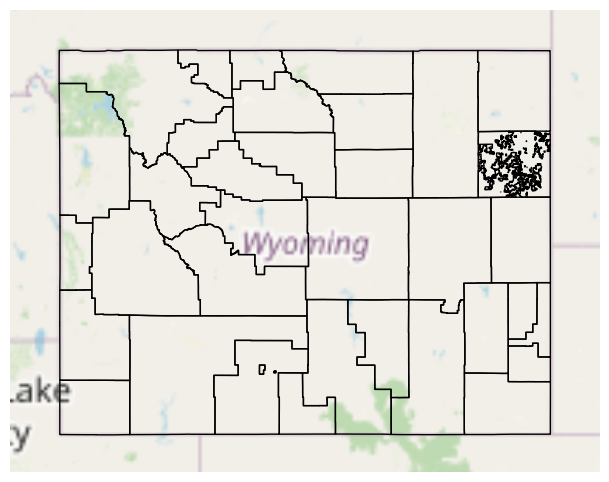

In [7]:
# Convert dataframe -to- geodataframe & plot
contiguous_usa = gpd.read_file(gplt.datasets.get_path('contiguous_usa')) # use for background map in subplot
ax = gplt.webmap(contiguous_usa, projection=gcrs.WebMercator()) # set subplot

dfru1 = dfru1[dfru1['Geometry'] != ""].reset_index(drop=True)
dfru1['Geometry'] = gpd.GeoSeries.from_wkt(dfru1['Geometry'], crs="EPSG:4326")
gdfru1 = gpd.GeoDataFrame(dfru1, geometry=dfru1['Geometry'], crs="EPSG:4326") # covert to geodataframe
gplt.polyplot(gdfru1, ax=ax)

In [8]:
# Create copy of water right sites dataframe
# Extract out WaterSourceTypeCV and match to that of above reportingunits dataframe

dfs1 = dfs.copy()
#nameOfWaterSourceTypeCV= "Surface and Groundwater" # change here for WaterSourceTypeCV of interest
dfs1 = dfs1[(dfs1['WaterSourceTypeCV'] == 'Groundwater') | (dfs1['WaterSourceTypeCV'] == 'Surface Water')]
dfs1 = dfs1[dfs1['PODorPOUSite'] == 'POD']
print(len(dfs1))
print(dfs1['WaterSourceTypeCV'].unique())
dfs1.head(1)

9768
['Groundwater' 'Surface Water']


,SiteUUID,RegulatoryOverlayUUIDs,WaterSourceUUIDs,CoordinateAccuracy,CoordinateMethodCV,County,EPSGCodeCV,Geometry,GNISCodeCV,HUC12,HUC8,Latitude,Longitude,NHDNetworkStatusCV,NHDProductCV,PODorPOUSite,SiteName,SiteNativeID,SitePoint,SiteTypeCV,StateCV,USGSSiteID,WaterSourceUUID,WaterSourceTypeCV
0,WYwr_SwadeID1,NaN,WYwr_WSwadeID1,WaDE Unspecified,WaDE Unspecified,WaDE Unspecified,4326,NaN,NaN,NaN,NaN,42.91290,-104.46127,NaN,NaN,POD,O W Well #1,wadeID1,NaN,Well,WY,NaN,WYwr_WSwadeID1,Groundwater


<GeoAxesSubplot: >

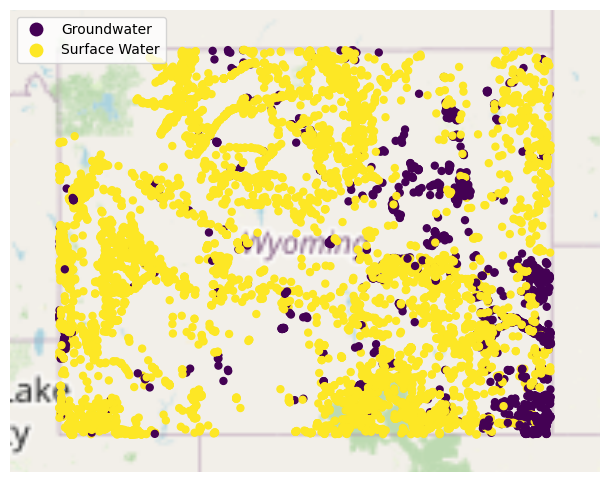

In [9]:
# Convert extracted water right sites -to- geodataframe & plot
contiguous_usa = gpd.read_file(gplt.datasets.get_path('contiguous_usa')) # use for background map in subplot
ax = gplt.webmap(contiguous_usa, projection=gcrs.WebMercator()) # set subplot

gdfs1 = gpd.GeoDataFrame(dfs1, geometry=gpd.points_from_xy(dfs1.Longitude.astype(float), dfs1.Latitude.astype(float)), crs="EPSG:4326")
gplt.pointplot(gdfs1, hue='WaterSourceTypeCV', legend=True, legend_var='hue', ax=ax)

In [10]:
# Select sites within polygon.
gdfs1_ru1 = gpd.sjoin(left_df=gdfs1, right_df=gdfru1[['ReportingUnitUUID', 'RegulatoryOverlayUUID', 'geometry']], op='within').replace(np.nan, "")
print(len(gdfs1_ru1))
gdfs1_ru1.head()

9750


C:\Users\rjame\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3466: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


,SiteUUID,RegulatoryOverlayUUIDs,WaterSourceUUIDs,CoordinateAccuracy,CoordinateMethodCV,County,EPSGCodeCV,Geometry,GNISCodeCV,HUC12,HUC8,Latitude,Longitude,NHDNetworkStatusCV,NHDProductCV,PODorPOUSite,SiteName,SiteNativeID,SitePoint,SiteTypeCV,StateCV,USGSSiteID,WaterSourceUUID,WaterSourceTypeCV,geometry,index_right,ReportingUnitUUID,RegulatoryOverlayUUID
0,WYwr_SwadeID1,,WYwr_WSwadeID1,WaDE Unspecified,WaDE Unspecified,WaDE Unspecified,4326,,,,,42.91290,-104.46127,,,POD,O W Well #1,wadeID1,,Well,WY,,WYwr_WSwadeID1,Groundwater,POINT (-104.46127 42.91290),9,WYre_RUwy18,WYre_RO18
745,WYwr_SwadeID10692,,WYwr_WSwadeID2581,WaDE Unspecified,WaDE Unspecified,WaDE Unspecified,4326,,,,,42.94122,-104.15988,,,POD,Kraft Ditch No Two,wadeID10692,,Stream,WY,,WYwr_WSwadeID2581,Surface Water,POINT (-104.15988 42.94122),9,WYre_RUwy18,WYre_RO18
755,WYwr_SwadeID10702,,WYwr_WSwadeID2583,WaDE Unspecified,WaDE Unspecified,WaDE Unspecified,4326,,,,,42.94619,-104.25512,,,POD,Jensen Portable Sprinkler,wadeID10702,,Stream,WY,,WYwr_WSwadeID2583,Surface Water,POINT (-104.25512 42.94619),9,WYre_RUwy18,WYre_RO18
764,WYwr_SwadeID10711,,WYwr_WSwadeID54,WaDE Unspecified,WaDE Unspecified,WaDE Unspecified,4326,,,,,42.89289,-104.73231,,,POD,Goss No I Ditch,wadeID10711,,Stream,WY,,WYwr_WSwadeID54,Surface Water,POINT (-104.73231 42.89289),9,WYre_RUwy18,WYre_RO18
8208,WYwr_SwadeID1757,,WYwr_WSwadeID1,WaDE Unspecified,WaDE Unspecified,WaDE Unspecified,4326,,,,,43.46289,-104.72137,,,POD,Aqua Holic Ww #1,wadeID1757,,Well,WY,,WYwr_WSwadeID1,Groundwater,POINT (-104.72137 43.46289),9,WYre_RUwy18,WYre_RO18


<GeoAxesSubplot: >

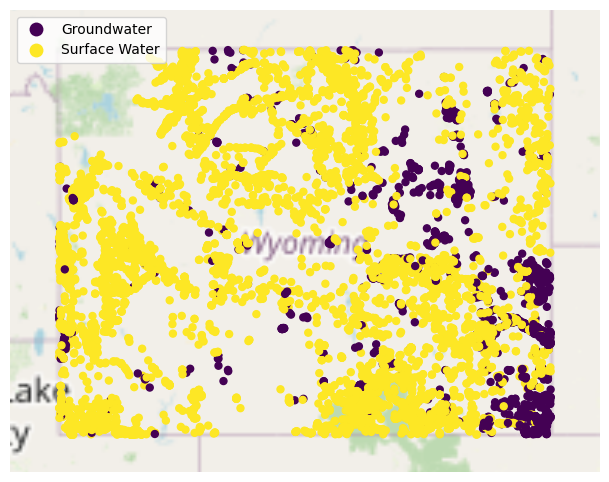

In [11]:
# plot the selected points
contiguous_usa = gpd.read_file(gplt.datasets.get_path('contiguous_usa')) # use for background map in subplot
ax = gplt.webmap(contiguous_usa, projection=gcrs.WebMercator()) # set subplot

gplt.pointplot(gdfs1_ru1, hue='WaterSourceTypeCV', legend=True, legend_var='hue', ax=ax)

In [12]:
# set RegulatoryOverlayUUIDs
gdfs1_ru1['RegulatoryOverlayUUIDs'] = gdfs1_ru1['RegulatoryOverlayUUID']
gdfs1_ru1 = gdfs1_ru1.drop(['RegulatoryOverlayUUID', 'geometry', 'index_right', 'ReportingUnitUUID', 'WaterSourceUUID', 'WaterSourceTypeCV'], axis=1)
gdfs1_ru1.head(1)

,SiteUUID,RegulatoryOverlayUUIDs,WaterSourceUUIDs,CoordinateAccuracy,CoordinateMethodCV,County,EPSGCodeCV,Geometry,GNISCodeCV,HUC12,HUC8,Latitude,Longitude,NHDNetworkStatusCV,NHDProductCV,PODorPOUSite,SiteName,SiteNativeID,SitePoint,SiteTypeCV,StateCV,USGSSiteID
0,WYwr_SwadeID1,WYre_RO18,WYwr_WSwadeID1,WaDE Unspecified,WaDE Unspecified,WaDE Unspecified,4326,,,,,42.91290,-104.46127,,,POD,O W Well #1,wadeID1,,Well,WY,


#### Regulatory Area Data #2

In [13]:
# dfru2 = dfru.copy()
# etc etc

## Concatenate all Regulatory Area Data Types together
- drop geometry from the wade wr sites.csv geodataframe

In [14]:
# Concatenate dataframes into single output
frames = [dfs, gdfs1_ru1] # list all out dataframes here
outdfs = pd.concat(frames)
outdfs = outdfs.drop_duplicates().reset_index(drop=True).replace(np.nan, "")
outdfs = outdfs.groupby('SiteUUID').agg(lambda x: ','.join([str(elem) for elem in (list(set(x))) if elem != ""])).replace(np.nan, "").reset_index()
print(len(outdfs))
outdfs.head(1)

71590


,SiteUUID,RegulatoryOverlayUUIDs,WaterSourceUUIDs,CoordinateAccuracy,CoordinateMethodCV,County,EPSGCodeCV,Geometry,GNISCodeCV,HUC12,HUC8,Latitude,Longitude,NHDNetworkStatusCV,NHDProductCV,PODorPOUSite,SiteName,SiteNativeID,SitePoint,SiteTypeCV,StateCV,USGSSiteID,WaterSourceUUID,WaterSourceTypeCV
0,WYwr_SwadeID1,WYre_RO18,WYwr_WSwadeID1,WaDE Unspecified,WaDE Unspecified,WaDE Unspecified,4326,,,,,42.9129,-104.46127,,,POD,O W Well #1,wadeID1,,Well,WY,,WYwr_WSwadeID1,Groundwater


# Inspect Output Data & Export

In [15]:
outdfs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71590 entries, 0 to 71589
Data columns (total 24 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   SiteUUID                71590 non-null  object
 1   RegulatoryOverlayUUIDs  71590 non-null  object
 2   WaterSourceUUIDs        71590 non-null  object
 3   CoordinateAccuracy      71590 non-null  object
 4   CoordinateMethodCV      71590 non-null  object
 5   County                  71590 non-null  object
 6   EPSGCodeCV              71590 non-null  object
 7   Geometry                71590 non-null  object
 8   GNISCodeCV              71590 non-null  object
 9   HUC12                   71590 non-null  object
 10  HUC8                    71590 non-null  object
 11  Latitude                71590 non-null  object
 12  Longitude               71590 non-null  object
 13  NHDNetworkStatusCV      71590 non-null  object
 14  NHDProductCV            71590 non-null  object
 15  PO

In [16]:
outdfs

,SiteUUID,RegulatoryOverlayUUIDs,WaterSourceUUIDs,CoordinateAccuracy,CoordinateMethodCV,County,EPSGCodeCV,Geometry,GNISCodeCV,HUC12,HUC8,Latitude,Longitude,NHDNetworkStatusCV,NHDProductCV,PODorPOUSite,SiteName,SiteNativeID,SitePoint,SiteTypeCV,StateCV,USGSSiteID,WaterSourceUUID,WaterSourceTypeCV
0,WYwr_SwadeID1,WYre_RO18,WYwr_WSwadeID1,WaDE Unspecified,WaDE Unspecified,WaDE Unspecified,4326,,,,,42.9129,-104.46127,,,POD,O W Well #1,wadeID1,,Well,WY,,WYwr_WSwadeID1,Groundwater
1,WYwr_SwadeID10,WYre_RO11,WYwr_WSwadeID1,WaDE Unspecified,WaDE Unspecified,WaDE Unspecified,4326,,,,,42.519136,-104.467717,,,POD,Frank Harris #2,wadeID10,,Well,WY,,WYwr_WSwadeID1,Groundwater
2,WYwr_SwadeID100,WYre_RO17,WYwr_WSwadeID1,WaDE Unspecified,WaDE Unspecified,WaDE Unspecified,4326,,,,,42.86266,-106.25622,,,POD,Texas Company #5,wadeID100,,Well,WY,,WYwr_WSwadeID1,Groundwater
3,WYwr_SwadeID1000,WYre_RO8,WYwr_WSwadeID1,WaDE Unspecified,WaDE Unspecified,WaDE Unspecified,4326,,,,,41.170561,-104.2651,,,POD,Minnick Ranch No. 1 Well,wadeID1000,,Well,WY,,WYwr_WSwadeID1,Groundwater
4,WYwr_SwadeID10000,WYre_RO24,WYwr_WSwadeID971,WaDE Unspecified,WaDE Unspecified,WaDE Unspecified,4326,,,,,41.63907,-106.71993,,,POD,Spring No 3 Ditch,wadeID10000,,Spring,WY,,WYwr_WSwadeID971,Surface Water
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71585,WYwr_SwadeID9995,WYre_RO24,WYwr_WSwadeID2043,WaDE Unspecified,WaDE Unspecified,WaDE Unspecified,4326,,,,,41.63093,-106.64952,,,POD,Wilson Ditch,wadeID9995,,Spring,WY,,WYwr_WSwadeID2043,Surface Water
71586,WYwr_SwadeID9996,WYre_RO15,WYwr_WSwadeID2252,WaDE Unspecified,WaDE Unspecified,WaDE Unspecified,4326,,,,,41.77123,-106.59266,,,POD,Dana Springs Ditch,wadeID9996,,Spring,WY,,WYwr_WSwadeID2252,Surface Water
71587,WYwr_SwadeID9997,WYre_RO24,WYwr_WSwadeID582,WaDE Unspecified,WaDE Unspecified,WaDE Unspecified,4326,,,,,41.60639,-106.59026,,,POD,Spring Ditch,wadeID9997,,Spring,WY,,WYwr_WSwadeID582,Surface Water
71588,WYwr_SwadeID9998,WYre_RO24,WYwr_WSwadeID969,WaDE Unspecified,WaDE Unspecified,WaDE Unspecified,4326,,,,,41.63696,-106.72698,,,POD,Spring No 1 Ditch,wadeID9998,,Spring,WY,,WYwr_WSwadeID969,Surface Water


In [17]:
# Export out to CSV.
outdfs.to_csv('ProcessedInputData/sites.csv', index=False) # this is in the Regulatory data folder